# import library

In [1]:
import pandas as pd
import numpy as np


import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Define Helper Functions

In [2]:
PATH = [os.path.join(os.getcwd(),"SAVEE","anger"),    # path of audio files
        os.path.join(os.getcwd(),"SAVEE","disgust"),
        os.path.join(os.getcwd(),"SAVEE","fear"),
        os.path.join(os.getcwd(),"SAVEE","happiness"),
        os.path.join(os.getcwd(),"SAVEE","neutral"),
        os.path.join(os.getcwd(),"SAVEE","sadness"),
        os.path.join(os.getcwd(),"SAVEE","surprise"),
        ]  
EMOTION = ["anger", "disguest", "fear", "happiness", "neutral", "sadness", "surprise"]

In [3]:
def extract_features(data):
    # calculate several features(return size vairies), take average values of all frames, and stack them together horizontally #(162,))
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0) # (1,)
    #print("zcr:", zcr.shape)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0) # (12,)
    #print("chroma:", chroma_stft.shape)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0) # (20,)
    #print("mfcc", mfcc.shape)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0) # (1,)
    #print("rms", rms.shape)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)  #(128,)
    #print("mel", mel.shape)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [4]:
print(os.path.join(PATH[0],os.listdir(PATH[0])[0]))

/Users/xinying/ML projects/Speech Emotion Recognition/SAVEE/anger/Ea14.wav


In [5]:
data, rate = librosa.load('SAVEE/anger/Da01.wav')

In [4]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.

data, sample_rate = librosa.load(os.path.join(PATH[0],os.listdir(PATH[0])[0]), sr=44010)
sample_rate

44010

In [5]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    #data, sample_rate = librosa.load(path, duration=2.5, offset=0.6, sr=44010)
    data, sample_rate = librosa.load(path, sr=44010)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [8]:
path = os.path.join(PATH[0],os.listdir(PATH[0])[1])
result = get_features(path)
result.shape

(3, 162)

In [6]:
path = os.path.join(PATH[0],os.listdir(PATH[0])[0])
sr = 44010
data_original,rate = librosa.load(path, sr=sr)
data_fast = librosa.effects.time_stretch(data_original,rate=2.0)
data_slow = librosa.effects.time_stretch(data_original, rate=0.5)
print(data_original.shape)
print(data_fast.shape)
print(data_slow.shape)

(309163,)
(154582,)
(618326,)


In [7]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

# Data Visualization

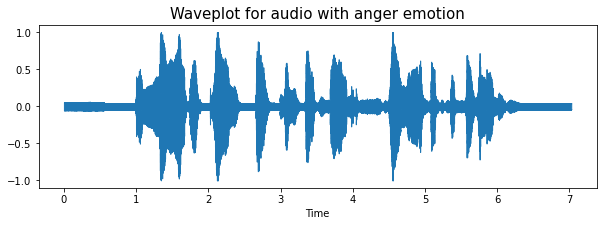

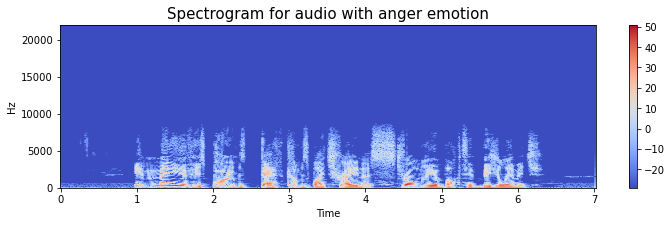

In [11]:
# data visualization: anger
data, sample_rate = librosa.load(os.path.join(PATH[0],os.listdir(PATH[0])[0]), sr=44010)
Audio(os.path.join(PATH[0],os.listdir(PATH[0])[0]),rate=44010)
create_waveplot(data, sr=44010,e="anger")
create_spectrogram(data, sr=44010, e="anger")

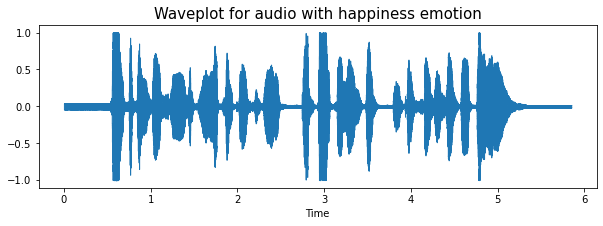

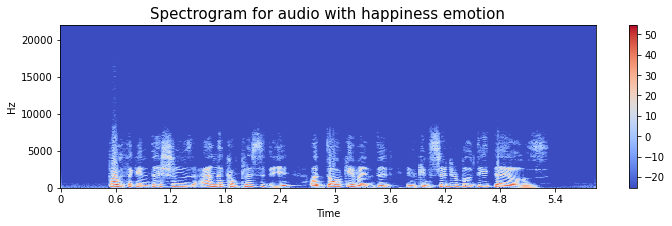

In [12]:
# data visualization: happiness
data, sample_rate = librosa.load(os.path.join(PATH[3],os.listdir(PATH[3])[0]), sr=44010)
Audio(os.path.join(PATH[0],os.listdir(PATH[0])[0]),rate=44010)
create_waveplot(data, sr=44010,e="happiness")
create_spectrogram(data, sr=44010, e="happiness")

# Feature Extraction

In [20]:
["something"] * 3

['something', 'something', 'something']

In [8]:
# feature extraction
data = []
label = []
for path,emotion in zip(PATH, EMOTION):
    for file in os.listdir(path):
        # (3, 162)
        feature = get_features(os.path.join(path, file))
        #  add 1 ndarray to data list and 3 labels to label list
        data.append(feature)
        label.extend([emotion]*3)

# data list: (480, )
# label list: (480*3, )
print(len(data))
print(len(label))

480
1440


In [9]:
# (3N,d) -> (1440,162)
utterance = len(data)
print(utterance)
data = np.stack(data).reshape(utterance * 3, -1)
print(data.shape)
# (3N,) -> (1440, )
label = np.array(label)
print(label.shape)


480
(1440, 162)
(1440,)


# SVM model

In [10]:
label_enc = LabelEncoder()
label_svm = np.expand_dims(label_enc.fit_transform(label), axis=1)
label_svm.shape

(1440, 1)

In [11]:
# data split
x_train, x_test, y_train, y_test = train_test_split(data, label_svm, random_state=0, shuffle=True)
# scaling data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1080, 162), (1080, 1), (360, 162), (360, 1))

In [12]:
# SVM
svm_model = SVC(C=1.0, kernel='rbf', probability=True)

# cross validation
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

# grid search
grid_params = {
                  'C': [0.001, 0.01, 0.1, 1.,10,100],
                  'gamma': [0.001, 0.01, 0.1, 1.,10,100]
              }
#grid_params = {'svm__' + key: grid_params[key] for key in grid_params}
scoring = ['balanced_accuracy', 'f1_weighted', 'roc_auc_ovr_weighted']
gs = GridSearchCV(estimator=svm_model, param_grid=grid_params, scoring=scoring,refit='roc_auc_ovr_weighted', cv=cv,verbose=0,error_score='raise')


In [13]:
# sys.stdout = open('log.txt', mode='w')
gs.fit(x_train,y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             error_score='raise', estimator=SVC(probability=True),
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1.0, 10, 100]},
             refit='roc_auc_ovr_weighted',
             scoring=['balanced_accuracy', 'f1_weighted',
                      'roc_auc_ovr_weighted'])

In [18]:
# sys.stdout = sys.__stdout__

gs.best_estimator_.get_params()
with open('log.txt', mode='w') as f:
    f.write(str(gs.best_estimator_.get_params()))

In [20]:
y_pred = gs.best_estimator_.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73        41
           1       0.83      0.70      0.76        43
           2       0.72      0.71      0.72        55
           3       0.76      0.76      0.76        45
           4       0.80      0.87      0.83        85
           5       0.73      0.82      0.77        39
           6       0.66      0.60      0.63        52

    accuracy                           0.75       360
   macro avg       0.75      0.74      0.74       360
weighted avg       0.75      0.75      0.75       360



# CNN model

In [22]:
# encoder = OneHotEncoder()
# label_cnn = encoder.fit_transform(np.expand_dims(label, axis=1)).toarray()
# print(label_cnn.shape)

(1440, 7)


In [30]:
# label_enc = LabelEncoder()
label_cnn = np.expand_dims(label_enc.fit_transform(label), axis=1)
label_cnn.shape

(1440, 1)

In [31]:
# data split
x_train_cnn, x_test_cnn, y_train_cnn, y_test_cnn = train_test_split(data, label_cnn, random_state=0, shuffle=True)
# scaling data
scaler = StandardScaler()
x_train_cnn = scaler.fit_transform(x_train_cnn)
x_test_cnn = scaler.transform(x_test_cnn)
x_train_cnn.shape, y_train_cnn.shape, x_test_cnn.shape, y_test_cnn.shape

((1080, 162), (1080, 1), (360, 162), (360, 1))

In [32]:
# making our data compatible to model.
x_train_cnn = np.expand_dims(x_train_cnn, axis=2)
x_test_cnn = np.expand_dims(x_test_cnn, axis=2)
x_train_cnn.shape, y_train_cnn.shape, x_test_cnn.shape, y_test_cnn.shape

((1080, 162, 1), (1080, 1), (360, 162, 1), (360, 1))

In [34]:
# CNN
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history = []

for train, test in kfold.split(x_train_cnn,y_train_cnn):
    model=Sequential()
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(units=1, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    # model.summary()
    history.append(model.fit(x_train_cnn, y_train_cnn, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp],verbose=0))

In [37]:
sys.stdout = sys.__stdout__

In [39]:
y_pred_cnn = model.predict(x_test_cnn)
print(classification_report(y_test_cnn, y_pred_cnn))

In [28]:
# import sys
# sys.stdout = open('log.txt', mode='a')
# rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
# history=model.fit(x_train_cnn, y_train_cnn, batch_size=64, epochs=200, validation_data=(x_test, y_test), callbacks=[rlrp],verbose=0)

ValueError: in user code:

    File "/Users/xinying/opt/anaconda3/envs/SER/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/Users/xinying/opt/anaconda3/envs/SER/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/xinying/opt/anaconda3/envs/SER/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/Users/xinying/opt/anaconda3/envs/SER/lib/python3.8/site-packages/keras/engine/training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "/Users/xinying/opt/anaconda3/envs/SER/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/xinying/opt/anaconda3/envs/SER/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/xinying/opt/anaconda3/envs/SER/lib/python3.8/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/xinying/opt/anaconda3/envs/SER/lib/python3.8/site-packages/keras/losses.py", line 1664, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/Users/xinying/opt/anaconda3/envs/SER/lib/python3.8/site-packages/keras/backend.py", line 4994, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 7) are incompatible


In [ ]:
sys.stdout = sys.__stdout__

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(200)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [ ]:
with open("AudioData/tmp.txt", mode="w") as fp:
    fp.write("this is a line\n")

In [ ]:
!rm AudioData/tmp.txt